In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ray
import pandas as pd
import seaborn as sns

In [3]:
_ = ray.init(num_cpus=12)

2020-12-02 00:08:29,533	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
from robust_gcn_structure import loader
from robust_gcn_structure.certification import certify

import time
import warnings

In [5]:
@ray.remote
def check(dataset, node_range, Q, q, solver="ECOS"):
    warnings.filterwarnings('ignore')
    times = []
    A, X, z = loader.load_dataset(dataset)
    weight_list = loader.load_network(dataset, False)

    kwargs = {
        'tolerance': 1e-2,
        'max_iter': 10
    }

    cert_count = 0
    uncert_count = 0
    not_sure = 0
    for i in node_range:
        eval_class = None
        target_node = i
        start = time.time()
        results = certify(target_node, A, X, weight_list, z,
                          local_changes=q,
                          global_changes=Q,
                          solver=solver, eval_class=eval_class,
                          use_predicted_class=True,
                          **kwargs)
        end = time.time()
        times.append(end - start)
        
        if results["all_robust"]:
            cert_count += 1
        else:
            changed = False
            for k in results:
                if type(results[k]) is dict and \
                        len(results[k].get("best_uppers", [])) == kwargs["max_iter"]:
                    not_sure += 1
                    changed = True

            if not changed:
                uncert_count += 1


    return (cert_count, uncert_count, not_sure), times

In [6]:
budgets = [(1, 1), (5, 3), (10, 5)]
datasets = ["citeseer", "cora_ml", "pubmed"]
node_range = range(0, 100)

In [7]:
res = []
for d in datasets:
    for b in budgets:
        res.append(check.remote(d, node_range, *b))

In [8]:
i = 0
cert_data = {"dataset": [], "budgets": [], "cert": [], "uncert": [], "not_sure": []}
time_data = {"node": [], "dataset": [], "budgets": [], "solving_time": []}

for d in datasets:
    for b in budgets:
        (cert, uncert, not_sure), times = ray.get(res[i])
        cert_data["dataset"].append(d)
        cert_data["budgets"].append(str(b))
        cert_data["cert"].append(cert)
        cert_data["uncert"].append(uncert)
        cert_data["not_sure"].append(not_sure)
        
        for n, t in zip(node_range, times):
            time_data["node"].append(n)
            time_data["dataset"].append(d)
            time_data["budgets"].append(str(b))
            time_data["solving_time"].append(t)
        
        i = i+1

In [9]:
cert_df = pd.DataFrame.from_dict(cert_data)
cert_df

,dataset,budgets,cert,uncert,not_sure
0,citeseer,"(1, 1)",91,9,0
1,citeseer,"(5, 3)",79,14,7
2,citeseer,"(10, 5)",75,15,10
3,cora_ml,"(1, 1)",78,20,2
4,cora_ml,"(5, 3)",39,36,25
5,cora_ml,"(10, 5)",17,38,46
6,pubmed,"(1, 1)",74,24,2
7,pubmed,"(5, 3)",49,44,7
8,pubmed,"(10, 5)",46,49,5


In [13]:
cert_df["cert"] /= 100
cert_df["uncert"] /= 100
cert_df["not_sure"] /= 100

In [14]:
cert_df

,dataset,budgets,cert,uncert,not_sure
0,citeseer,"(1, 1)",0.91,0.09,0.00
1,citeseer,"(5, 3)",0.79,0.14,0.07
2,citeseer,"(10, 5)",0.75,0.15,0.10
3,cora_ml,"(1, 1)",0.78,0.20,0.02
4,cora_ml,"(5, 3)",0.39,0.36,0.25
5,cora_ml,"(10, 5)",0.17,0.38,0.46
6,pubmed,"(1, 1)",0.74,0.24,0.02
7,pubmed,"(5, 3)",0.49,0.44,0.07
8,pubmed,"(10, 5)",0.46,0.49,0.05


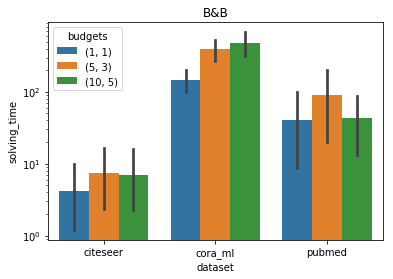

In [17]:
time_df = pd.DataFrame.from_dict(time_data)
g = sns.barplot(data=time_df, x="dataset", y="solving_time", hue="budgets")
g.set(title="B&B")
g.set_yscale("log")

In [12]:
cert_df.to_csv("res/bb_cert.csv")
time_df.to_csv("res/bb_time.csv")